# Class imbalance

### digits dataset   
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html 

In [36]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [37]:
# It is originally well-balanced dataset.
digits = load_digits() 

# For our practice, I will make an imbalanced dataset from this dataset. 
# I converted class 9 to a positive class and converted all other classes to a negative class.
X = digits.data
y = digits.target == 9

In [38]:
# now this is an imbalanced dataset.
# Negatives are almost ten times as many as positives.
np.unique(y, return_counts=True)

(array([False,  True]), array([1617,  180]))

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, stratify=y, random_state=0) 
# stratified split could be important because this is an imbalanced dataset.

In [40]:
# distribution of training set
np.unique(y_train, return_counts=True)

(array([False,  True]), array([1212,  135]))

#### None (no additional process)

- just use DecisionTreeClassifier in this example
    - of course, you can use other classification algorithms. 

In [41]:
tree = DecisionTreeClassifier(max_depth=20).fit(X_train, y_train) 
y_test_hat = tree.predict(X_test)

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

false negative 는 두번째 row 첫번째 컬럼

In [43]:
print(confusion_matrix(y_test, y_test_hat))
print("Test score: {:.2f}".format(accuracy_score(y_test, y_test_hat)))
print("Test f1 score: {:.2f}".format(f1_score(y_test, y_test_hat)))

[[397   8]
 [ 10  35]]
Test score: 0.96
Test f1 score: 0.80


roc_courve : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
- it returns fpr, tpr and all threshold values used in their calculations.

AUC : 0.8790123456790123


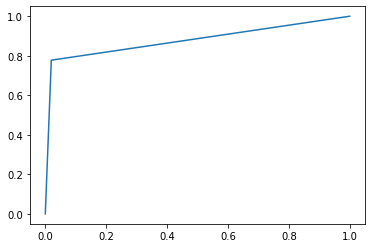

In [44]:
# this is how to draw the ROC curve
# _ 는 threshold이다
fpr, tpr, _ = roc_curve(y_test , tree.predict_proba(X_test)[:,1])
# roc curve 그리기
plt.plot(fpr, tpr)
print("AUC : {}".format(roc_auc_score(y_test , tree.predict_proba(X_test)[:,1]))) # predicted probabilities of postive

#### Cost sensitive

In [45]:
# All we have to do is set the 'class_weight'.
# Almost all models in scikit-learn provides the 'class_weight' argument that can be specified as a model hyperparameter.
tree = DecisionTreeClassifier(max_depth=20, class_weight='balanced').fit(X_train, y_train)
y_test_hat = tree.predict(X_test)

- If we set this argument as ‘balanced', it automatically adjust weights inversely proportional to class frequencies in the input data.
- In case of this dataset, ...

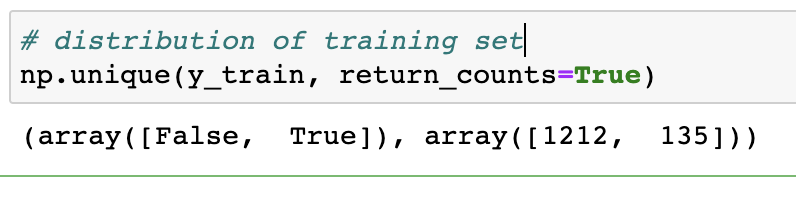

class_weight='balanced'를 쓰면

1212:negative, 135:positive => weight가 proportional하게 바뀐다 1/1212:1/135

In [46]:
np.unique(y_train, return_counts=True)

(array([False,  True]), array([1212,  135]))

Test score: 0.97
Test f1 score: 0.86
[[400   5]
 [  7  38]]
AUC : 0.9160493827160494


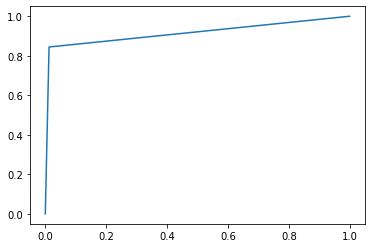

In [47]:
print("Test score: {:.2f}".format(accuracy_score(y_test, y_test_hat)))
print("Test f1 score: {:.2f}".format(f1_score(y_test, y_test_hat)))
print(confusion_matrix(y_test, y_test_hat))

fpr, tpr, _ = roc_curve(y_test , tree.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
print("AUC : {}".format(roc_auc_score(y_test , tree.predict_proba(X_test)[:,1])))

- Cost sensitive learning does not necessarily lead to better results. It should be treated like a hyperparameter.

#### Random Oversampling

In [73]:
over_no = y_train.sum()*9

In [76]:
over_no

1215

replace = True로 해야 많은 샘플을 얻을 수 있다

In [74]:
positive_index=y_train.nonzero()[0]
over_index = np.random.choice(positive_index,over_no, replace=True)

In [75]:
X_train_add = X_train[over_index,:]
y_train_add = y_train[over_index]

In [77]:
X_train_over = np.concatenate((X_train,X_train_add))
y_train_over = np.concatenate((y_train,y_train_add))

In [78]:
np.unique(y_train_over, return_counts = True)

(array([False,  True]), array([1212, 1350]))

In [80]:
tree = DecisionTreeClassifier(max_depth = 20).fit(X_train_over,y_train_over)
y_test_hat = tree.predict(X_test)

test set에는 oversampling 적용 금지!

Test score: 0.96
Test f1 score: 0.78
[[400   5]
 [ 13  32]]
AUC : 0.8493827160493828


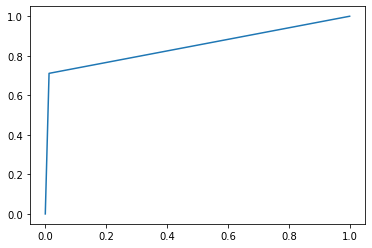

In [82]:
print("Test score: {:.2f}".format(accuracy_score(y_test, y_test_hat)))
print("Test f1 score: {:.2f}".format(f1_score(y_test, y_test_hat)))
print(confusion_matrix(y_test, y_test_hat))

fpr, tpr, _ = roc_curve(y_test , tree.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
print("AUC : {}".format(roc_auc_score(y_test , tree.predict_proba(X_test)[:,1])))

- oversampling does not necessarily lead to better results.

#### Random Undersampling

In [86]:
X_train_major = X_train[y_train==0]
X_train_minor = X_train[y_train==1]

y_train_major = y_train[y_train==0]
y_train_minor = y_train[y_train==1]

replace=Fasle는 디자인의 차이임!

In [87]:
# 위에 나와있음
under_no = 135

under_idx = np.random.choice(X_train_major.shape[0],under_no,replace=False)

X_train_major_under = X_train_major[under_idx,:]
y_train_major_under = y_train_major[under_idx]

In [89]:
X_train_under = np.concatenate((X_train_minor, X_train_major_under))
y_train_under = np.concatenate((y_train_minor, y_train_major_under))

In [90]:
np.unique(y_train_under, return_counts=True)

(array([False,  True]), array([135, 135]))

In [91]:
tree = DecisionTreeClassifier(max_depth=20).fit(X_train_under,y_train_under)
y_test_hat = tree.predict(X_test)

Test score: 0.86
Test f1 score: 0.55
[[348  57]
 [  6  39]]
AUC : 0.8629629629629629


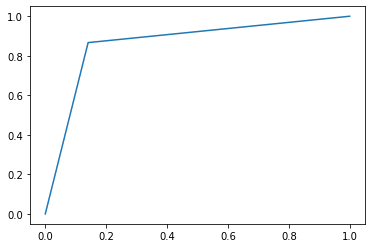

In [93]:
print("Test score: {:.2f}".format(accuracy_score(y_test, y_test_hat)))
print("Test f1 score: {:.2f}".format(f1_score(y_test, y_test_hat)))
print(confusion_matrix(y_test, y_test_hat))

fpr, tpr, _ = roc_curve(y_test , tree.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
print("AUC : {}".format(roc_auc_score(y_test , tree.predict_proba(X_test)[:,1])))

- Undersampling does not necessarily lead to better results.
- The results will be very different each time t. If important samples are deleted during the undersampling process, performance will drop significantly.

### try to use imblearn package
- https://imbalanced-learn.org/stable/index.html